In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)

import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

C:\Users\Yang\AppData\Local\Continuum\anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Approach 2
As the SARIMA models used only one AR term to forecast, another approach is to use RandomForest Regressor with higher orders of time lags as features to predict the target variable.  

RandomForest is choosen because of its flexibility to handle non-linear distributions.  

Include binary variables to indicate holidays and weekends to capture variance on these days vs business days.  

To compare with the SARIMA and SARIMAX models, I will run a model without the weather attributes (max_temperature_f and precipitation_inches) and then another model with the weather attributes to compare the performance.  

In [2]:
# Load time series
sf_day_ts = pd.read_pickle('sf_day_ts.pkl')

In [3]:
features_df = sf_day_ts.copy()

# Shift the time series to get time lags from 1 to 14
for i in range(1,15):
    features_df['t_'+str(i)] = features_df['trips'].shift(i)

features_df = features_df[14:]

In [4]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Get the federal holidays in the time span
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=features_df.index[0], end=features_df.index[-1])

# Column to indicate days that are holidays
features_df['isholiday'] = features_df.index.isin(holidays)
features_df['isholiday'] = features_df['isholiday'].apply(lambda x: 1 if x==True else 0)

# Column to indicate weekends 
features_df['weekday'] = features_df.index.weekday  # .weekday returns 0 to 6(Monday=0, Sunday=6)
features_df['isweekend'] = features_df['weekday'].apply(lambda x: 1 if (x==5) or (x==6) else 0)
features_df = features_df.drop(columns=['weekday'])

# Column to indicate the month of each date
features_df['month'] = features_df.index.month

In [5]:
# Set up x and y variables for the model
y = features_df['trips']
x = features_df.iloc[:,1:]

In [6]:
# Define a function that predicts trips using a Random Forest Regressor
# splits the data into train and test and returns the predicted values

def rfr_forecast(x_data, y_data, start_forecast_date):
    # Transform the start_forecast_date into datetime object
    delta = pd.Timedelta(days=1)  # L-1 difference
    forecast = datetime.strptime(start_forecast_date, '%Y-%m-%d')

    # Split the data into train, test at 2015-04-01
    x_train = x_data[:(forecast-delta).date()]
    x_test = x_data[forecast.date()::]

    y_train = y.loc[:(forecast-delta).date()]
    y_test = y.loc[forecast.date()::]
    
    rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1)
    rfr.fit(x_train, y_train)

    # See which features are more important in the model
    features = pd.Series(rfr.feature_importances_, index=x_data.columns)
    print('Top 5 features for prediction:')
    print(features.sort_values(ascending=False)[0:5])
    
    # Use the model to predict over the test period
    y_test_pred = pd.Series(rfr.predict(x_test).astype('int32'),index=y_test.index)
    
    # Predict over the train period and combine with test period in order to calculate residuals
    y_train_pred = pd.Series(rfr.predict(x_train).astype('int32'),index=y_train.index)
    
    total_pred = pd.concat([y_train_pred, y_test_pred], axis=0)
    
    # Plot both the actual data and forecasted data
    fig = plt.figure(figsize=(18,18))
    ax1 = fig.add_subplot(311)
    ax1.set_title('Actual number of trips vs Predicted number of trips')
    plt.plot(y_test, 'b-', label='actual')
    plt.plot(y_test_pred, 'r--', label='predicted')
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Trips')
    ax1.legend(loc='best')

    print(' ')
    print('Random Forest Regressor Model - from {}'.format(start_forecast_date))
    print('='*50)
    print('R2 score on test data: {}'.format(r2_score(y_test, y_test_pred)))

    # Calculate the absolute error in the prediction vs actual number of trips
    abs_error = (y_test - y_test_pred).abs()

    # Calculate the percentage error = absolute_error / actual trips
    percent_error = abs_error / y_test

    print(' ')
    print('Average absolute error: {}'.format(abs_error.mean()))
    print('Average percentage error: {}'.format(percent_error.mean()))

    # calculate the residuals of predict vs actual
    residuals = pd.concat([y_train, y_test], axis=0) - total_pred

    # Check the ACF and PACF plot of the residuals
    ax2 = fig.add_subplot(312)
    plot_acf(residuals, ax=ax2, title='Autocorrelation of the residuals')
    ax3 = fig.add_subplot(313)
    plot_pacf(residuals, ax=ax3, title='Partial autocorrelation of the residuals')
    
    return None

Top 5 features for prediction:
isweekend    0.645795
t_1          0.076417
t_7          0.062465
isholiday    0.039825
t_5          0.029098
dtype: float64
 
Random Forest Regressor Model - from 2015-04-01
R2 score on test data: 0.9521850513303196
 
Average absolute error: 62.411764705882355
Average percentage error: 0.09880181547496468


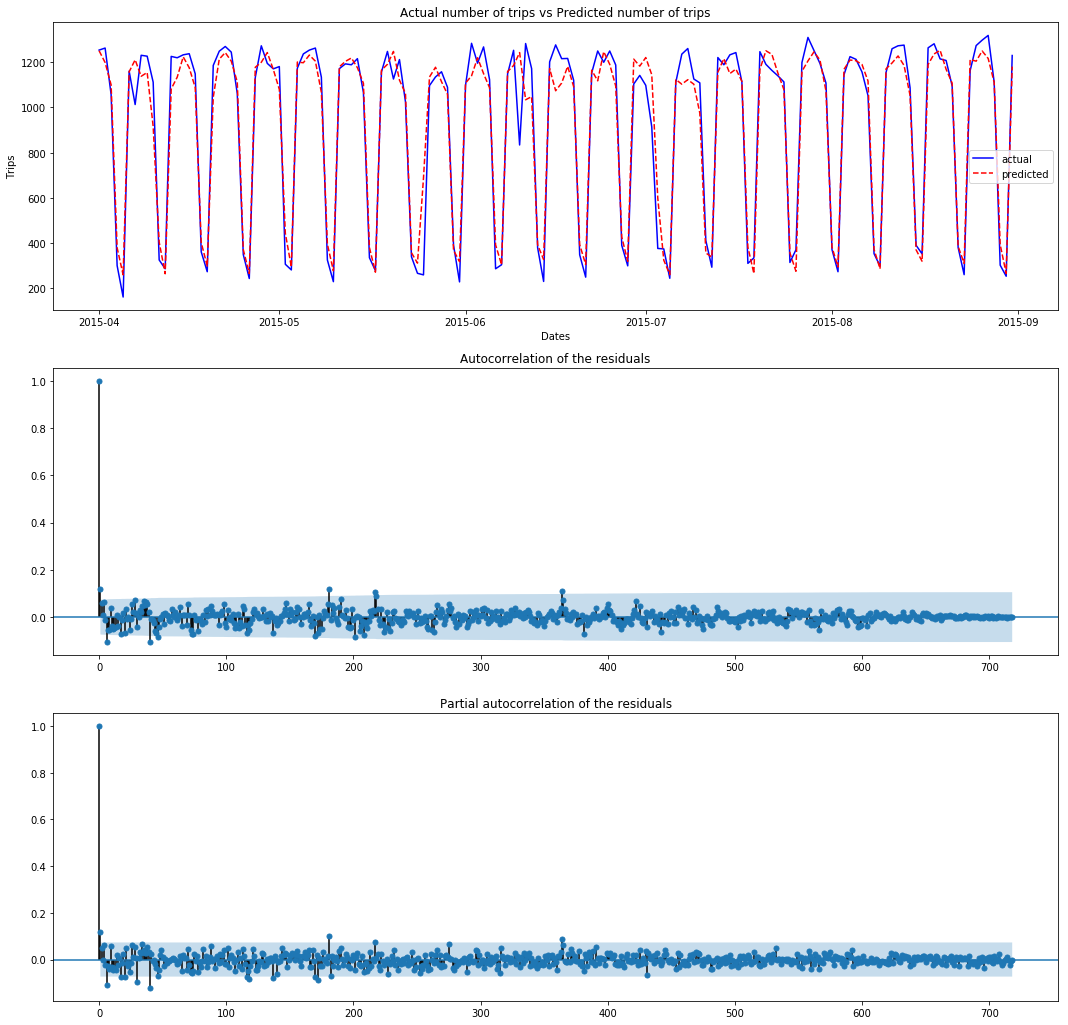

In [7]:
# Random Forest Regressor without weather attributes forecasting from 1st April 2015
rfr_forecast(x, y, '2015-04-01')

Top 5 features for prediction:
isweekend    0.665692
t_7          0.074016
t_1          0.066361
isholiday    0.041901
t_5          0.024271
dtype: float64
 
Random Forest Regressor Model - from 2015-06-01
R2 score on test data: 0.9563927643965257
 
Average absolute error: 57.80434782608695
Average percentage error: 0.07817685453961175


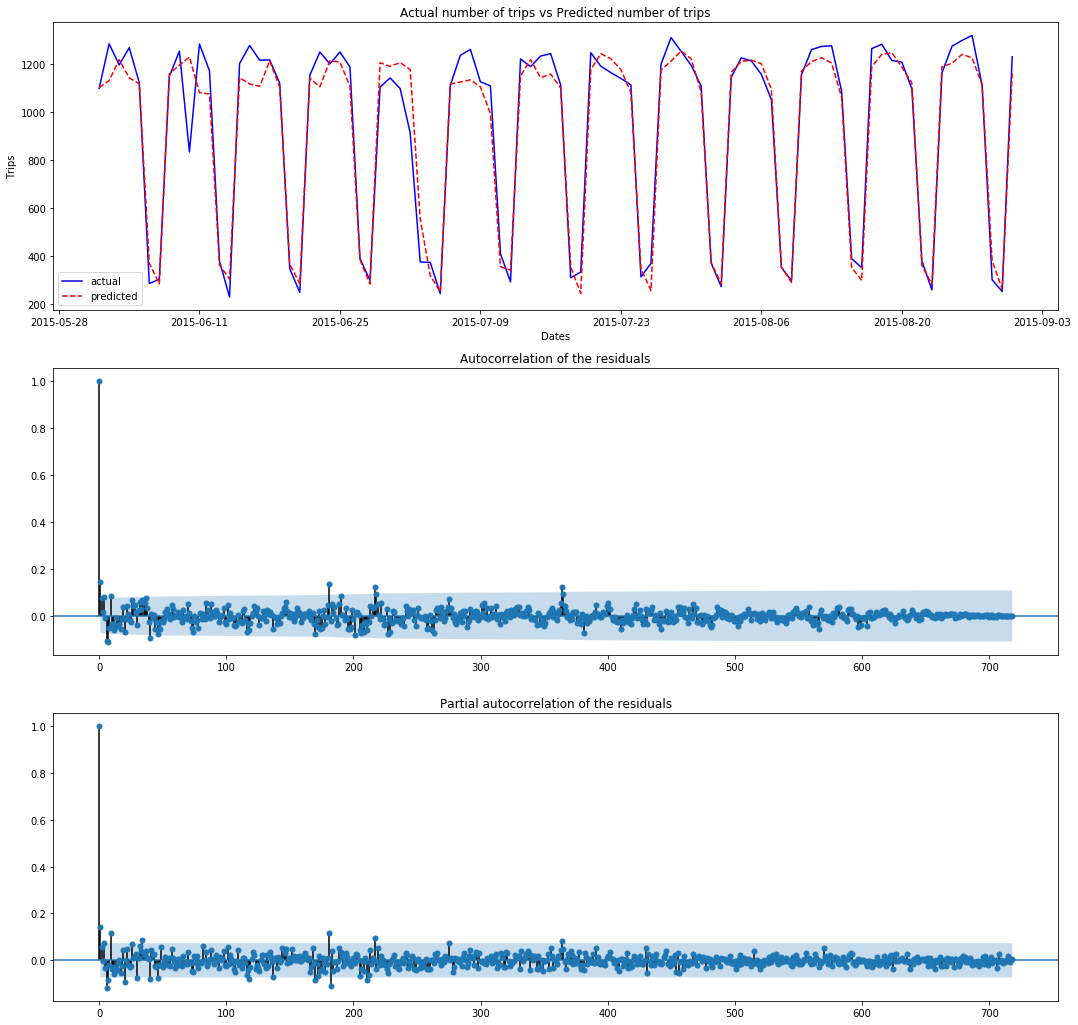

In [8]:
# Random Forest Regressor without weather attributes forecasting from 1st June 2015
rfr_forecast(x, y, '2015-06-01')

Include the weather attributes and run the RandomForest Regressor again

In [9]:
# Load weather data from the pickled file
sf_weather = pd.read_pickle('sf_weather.pkl')
sf_weather = sf_weather.set_index('date')

In [10]:
exo_list = ['max_temperature_f', 'precipitation_inches']

In [11]:
# Join the weather attributes
x_w = x.join(sf_weather[['max_temperature_f', 'precipitation_inches']])

Top 5 features for prediction:
isweekend            0.648014
max_temperature_f    0.059403
t_1                  0.055625
t_7                  0.052860
isholiday            0.038732
dtype: float64
 
Random Forest Regressor Model - from 2015-04-01
R2 score on test data: 0.9628025324699707
 
Average absolute error: 55.98039215686274
Average percentage error: 0.08957669724320806


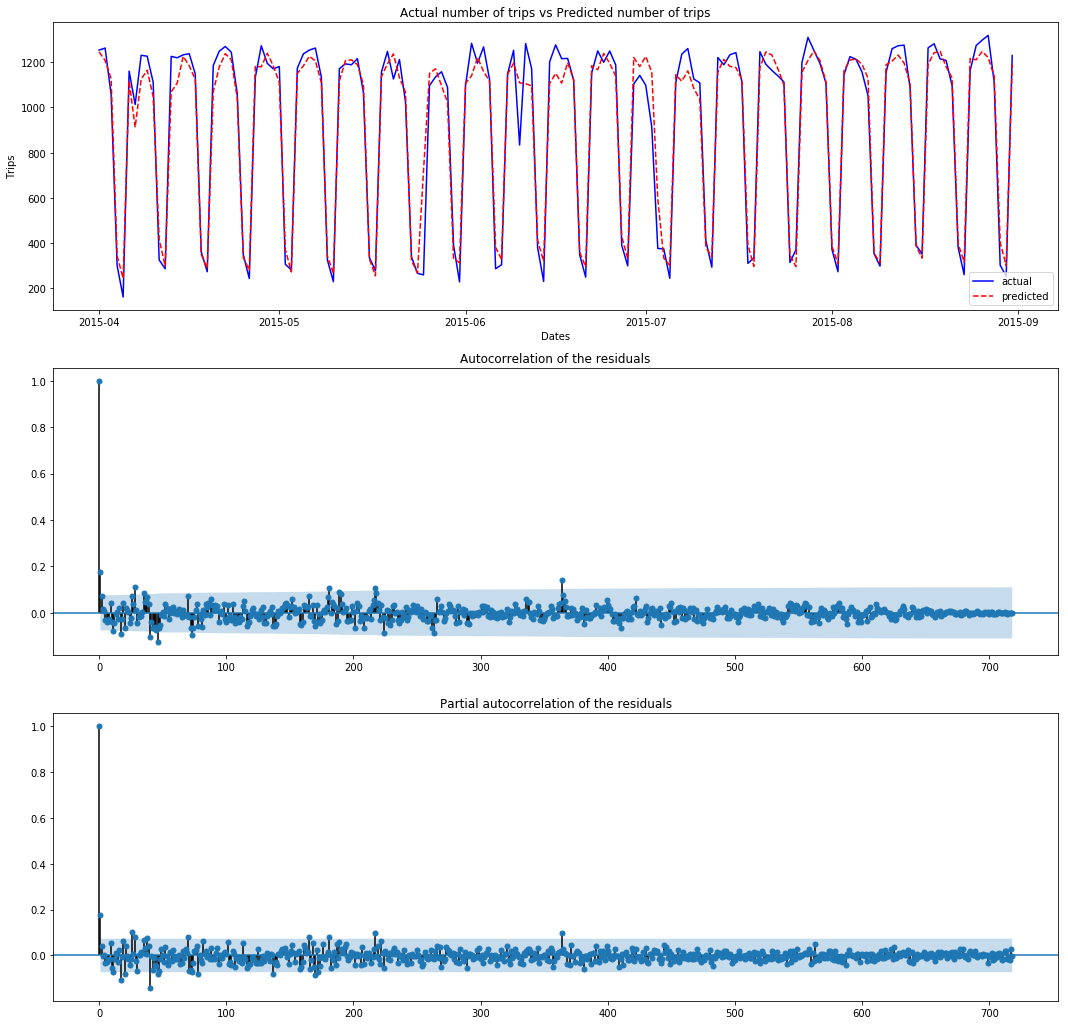

In [12]:
# Random Forest Regressor forecasting from 1st April 2015
rfr_forecast(x_w, y, '2015-04-01')

Top 5 features for prediction:
isweekend            0.666998
t_7                  0.063255
t_1                  0.058063
isholiday            0.040586
max_temperature_f    0.036223
dtype: float64
 
Random Forest Regressor Model - from 2015-06-01
R2 score on test data: 0.9688823591928372
 
Average absolute error: 52.69565217391305
Average percentage error: 0.0751772589774343


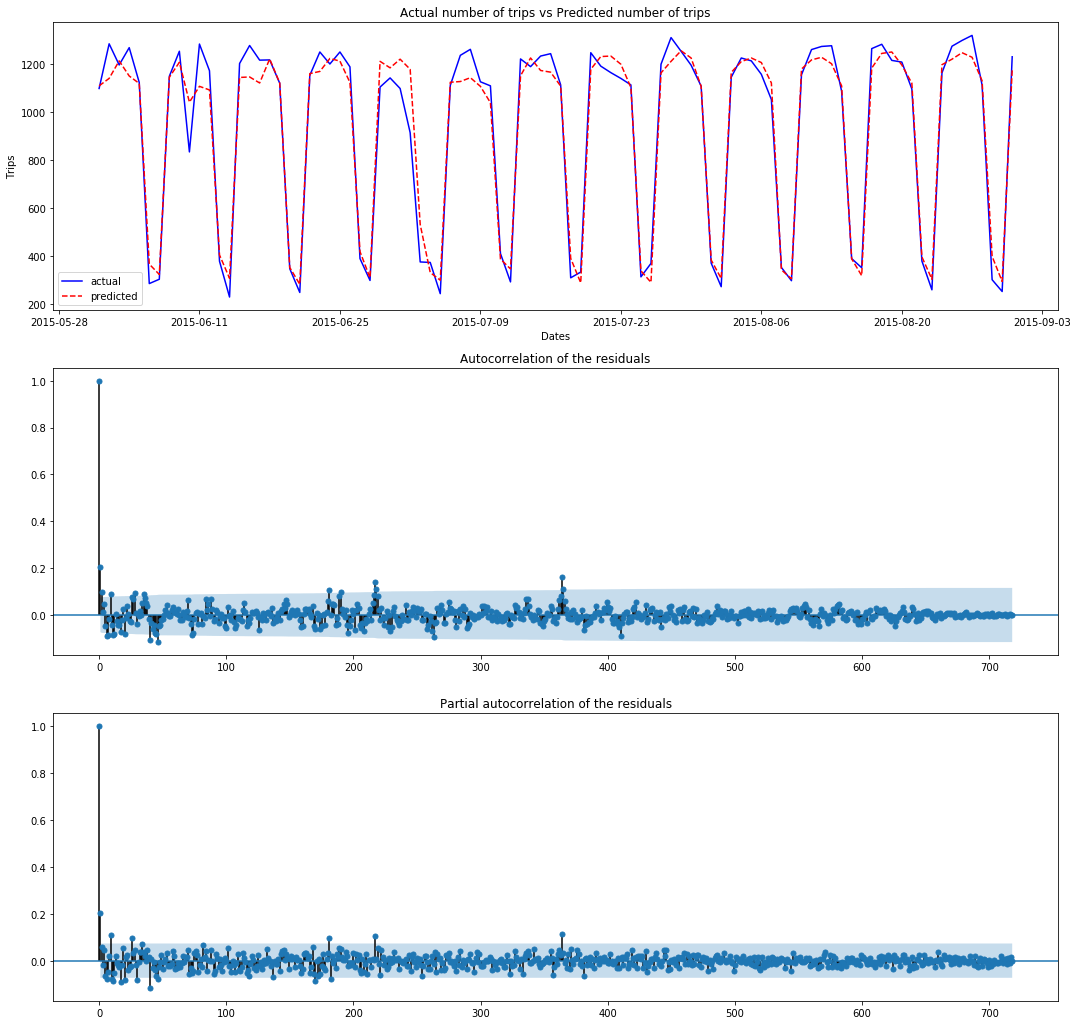

In [13]:
# Random Forest Regressor forecasting from 1st June 2015
rfr_forecast(x_w, y, '2015-06-01')

## Summary of results

   |RandomForest (no weather) | RandomForest (with weather)
:----:|:-----------------:|:--------------------:
Apr-1 |R2 = 0.953         |**R2 = 0.963**         
      |Avg AbsErr = 62    |**Avg AbsErr = 56**   
      |Avg %AbsErr = 9.9% |**Avg %AbsErr = 8.9%** 
Jun-1 |R2 = 0.957         |**R2 = 0.970**         
      |Avg AbsErr = 57    |**Avg AbsErr = 52**   
      |Avg %AbsErr = 7.7% |**Avg %AbsErr = 7.4%** 


### Findings
- The Random Forest regressor performed slightly better than the SARIMAX models  
- Another advantage of Random Forest regressor is that it is able to highlight which are the most important predictors of the output, which in this case, unsurprisingly is the weekend indicator
- Unfortunately, there are still some autocorrelation in the residuals that the model was unable to capture